TCLab version 1.0.0
Simulated TCLab


Policy Rollout: 100%|██████████| 240/240 [00:00<00:00, 1852.87it/s]


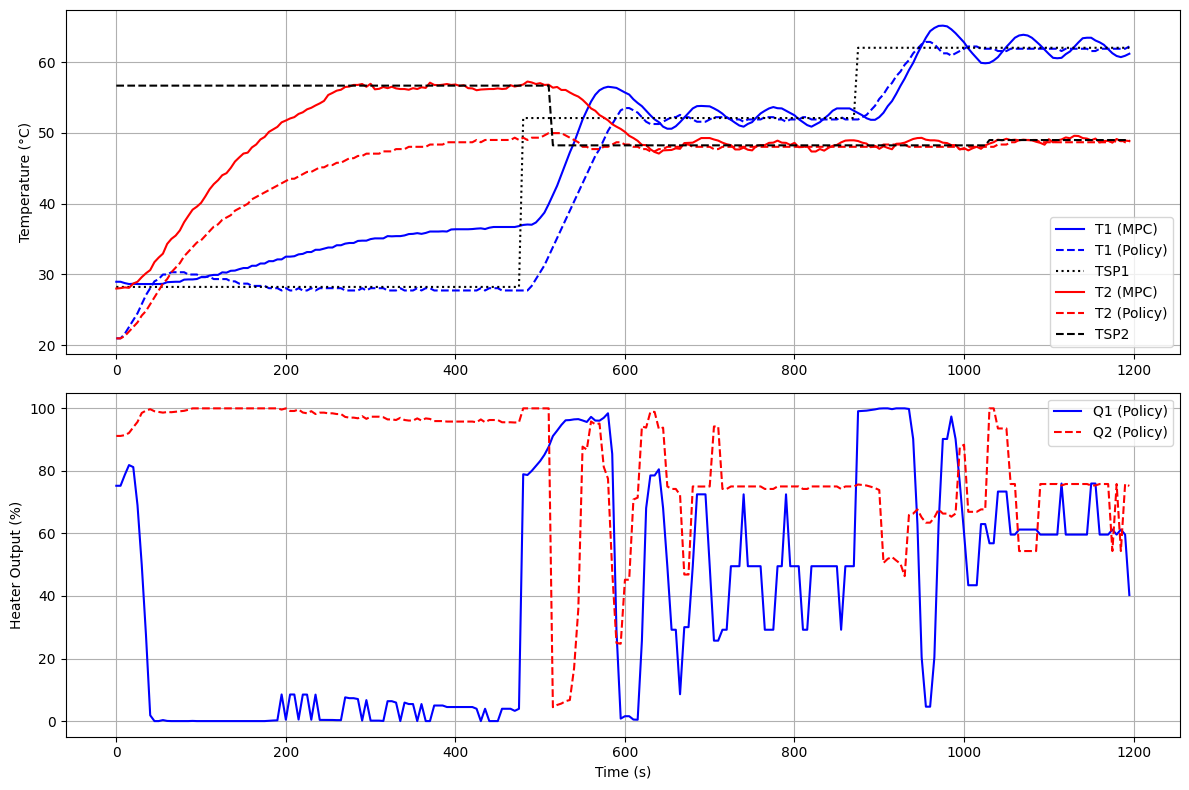

In [10]:
# 단일 비교 실험 
import numpy as np
import pandas as pd
import torch
import math
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import trange
from tclab import setup
#from policy import GaussianPolicy
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import sys
sys.path.append("C:/Users/Developer/TCLab/IQL")  # src/가 포함된 상위 폴더
from src.policy import GaussianPolicy


# === 설정 ===
#CSV_PATH = "C:\\Users\\Developer\\TCLab\\csv\\mpc_episode_22_data.csv"  # 여기 실제 MPC 데이터 경로 넣기
CSV_PATH = "C:\\Users\\Developer\\TCLab\\csv\\data_back4\\mpc_episode_27_data.csv"
#MODEL_PATH = "C:\\Users\\Develop\er\\TCLab\\IQL\\logs\\mpc-iql\\04-23-25_14.45.10_ukeq\\final.pt"  # 학습된 정책 .pt 경로
MODEL_PATH ="C:\\Users\\Developer\\TCLab\\IQL\\runs\\tclab-mpc-iql\\04-25-25_final_3e-4_lr\\final.pt"

DEFAULT_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def torchify(x):
    x = torch.from_numpy(x)
    if x.dtype is torch.float64:
        x = x.float()
    x = x.to(device=DEFAULT_DEVICE)
    return x


# === CSV 로부터 MPC 결과 불러오기 ===
df = pd.read_csv(CSV_PATH)
t = df['Time'].to_numpy()
T1_mpc = df['T1'].to_numpy()
T2_mpc = df['T2'].to_numpy()
Tsp1 = df['TSP1'].to_numpy()
Tsp2 = df['TSP2'].to_numpy()

# === 시뮬레이터 환경 설정 ===
lab = setup(connected=False)
env = lab(synced=False)
env.Q1(0); env.Q2(0)

# === 학습된 정책 불러오기 ===
policy = GaussianPolicy(obs_dim=4, act_dim=2)
ckpt = torch.load(MODEL_PATH, map_location="cpu")
policy.load_state_dict({k.replace("policy.", ""): v for k, v in ckpt.items() if k.startswith("policy.")})
policy.eval()

# === 정책 기반 roll-out ===
steps = len(t)
dt = int(np.diff(t).mean())  # CSV에서 시간 간격 추정
T1_rl = np.zeros(steps)
T2_rl = np.zeros(steps)
Q1_rl = np.zeros(steps)
Q2_rl = np.zeros(steps)

for k in trange(steps, desc="Policy Rollout"):
    env.update(t=k * dt)
    T1_rl[k] = env.T1
    T2_rl[k] = env.T2

    obs = np.array([T1_rl[k], T2_rl[k], Tsp1[k], Tsp2[k]], dtype=np.float32)
    with torch.no_grad():
        act = policy.act(torchify(obs), deterministic=True).cpu().numpy()

    Q1_rl[k] = float(np.clip(act[0], 0, 100))
    Q2_rl[k] = float(np.clip(act[1], 0, 100))
    env.Q1(Q1_rl[k]); env.Q2(Q2_rl[k])

env.Q1(0); env.Q2(0)

# === 결과 시각화 ===
plt.figure(figsize=(12, 8))
plt.subplot(2,1,1)
plt.plot(t, T1_mpc, 'b-', label="T1 (MPC)")
plt.plot(t, T1_rl, 'b--', label="T1 (Policy)")
plt.plot(t, Tsp1, 'k:', label="TSP1")
plt.plot(t, T2_mpc, 'r-', label="T2 (MPC)")
plt.plot(t, T2_rl, 'r--', label="T2 (Policy)")
plt.plot(t, Tsp2, 'k--', label="TSP2")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(t, Q1_rl, 'b-', label="Q1 (Policy)")
plt.plot(t, Q2_rl, 'r--', label="Q2 (Policy)")
plt.xlabel("Time (s)")
plt.ylabel("Heater Output (%)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig("compare_policy_vs_mpc.png")
plt.show()
